<a href="https://colab.research.google.com/github/qn19325/individualProject/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class ImageDataLoader(Dataset):
    def __init__(self, dir_=None):
        self.data_df = pd.read_csv('data.csv')
        self.dataset_len = len(self.data_df) # read the number of len of your csv files
    def __getitem__(self, idx):
        # load the next image
        f_name_t = self.data_df['Filename'][idx]
        f_name_tp1 = self.data_df['Filename'][idx+1]
        label = self.data_df['Label'][idx]
        img_t = torchvision.io.read_image('trainingData/{}'.format(f_name_t))
        img_tp1 = torchvision.io.read_image('trainingData/{}'.format(f_name_tp1))
        img_t = img_t.flatten(1,-1).float().div_(255.0)
        img_tp1 = img_tp1.flatten(1,-1).float().div_(255.0)
        input_seq = torch.cat((img_t, img_tp1), dim=0)
        return input_seq, label
    def __len__(self):
        return self.dataset_len - 1

In [4]:
dataset = ImageDataLoader()
dataloader = DataLoader(dataset, shuffle=False, batch_size=8)

Batch: 19


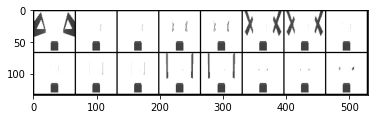

In [130]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imagesList = []
for idx, (images, labels) in enumerate(dataloader):
  images = images.reshape(-1,1,64,64)
  imagesList.append(images)

randomBatch = random.randrange(0,len(imagesList))
print('Batch:', randomBatch)
imshow(torchvision.utils.make_grid(imagesList[randomBatch]))

In [141]:
num_epochs = 10
learning_rate = 0.001
input_size = 4096
output_size = 1
sequence_length = 2
hidden_size = 128
num_layers = 2

In [133]:
class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [134]:
model = RNN(8, sequence_length, input_size, hidden_size, output_size)

In [131]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [137]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  0 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  1 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  2 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  3 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  4 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  5 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  6 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  7 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  8 | Loss: 3707.4106 | Train Accuracy: 9.68
Epoch:  9 | Loss: 3707.4106 | Train Accuracy: 9.68


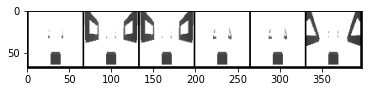

In [143]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(dataloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data

        # check image inputs
        images = inputs.reshape(-1,1,64,64)
        imshow(torchvision.utils.make_grid(images))

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, 8)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))